In [58]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

# Load the data
file_paths = [
    'Binary Labeled Data/bag_toss_binary.csv',
    'Binary Labeled Data/sitting_up_and_down_binary.csv',
    'Binary Labeled Data/stairs_binary.csv',
    'Binary Labeled Data/standing_binary.csv',
    'Binary Labeled Data/walking_binary.csv'
]
data_frames = [pd.read_csv(file_path) for file_path in file_paths]
combined_data = pd.concat(data_frames)



29260
[0 0 0 ... 0 0 0]
0.016952054794520548
{0: 0.5078260869565218, 1: 32.44444444444444}
Epoch 1/50
59/59 [==============================] - 7s 52ms/step - loss: 0.3776 - accuracy: 0.8895 - val_loss: 0.2115 - val_accuracy: 0.9123
Epoch 2/50
59/59 [==============================] - 2s 39ms/step - loss: 0.1301 - accuracy: 0.9307 - val_loss: 0.1793 - val_accuracy: 0.9401
Epoch 3/50
59/59 [==============================] - 2s 38ms/step - loss: 0.0951 - accuracy: 0.9526 - val_loss: 0.1150 - val_accuracy: 0.9561
Epoch 4/50
59/59 [==============================] - 2s 39ms/step - loss: 0.0877 - accuracy: 0.9583 - val_loss: 0.1054 - val_accuracy: 0.9561
Epoch 5/50
59/59 [==============================] - 2s 39ms/step - loss: 0.0802 - accuracy: 0.9604 - val_loss: 0.2251 - val_accuracy: 0.9412
Epoch 6/50
59/59 [==============================] - 2s 41ms/step - loss: 0.1052 - accuracy: 0.9438 - val_loss: 0.1653 - val_accuracy: 0.9497
Epoch 7/50
59/59 [==============================] - 2s 39ms/ste

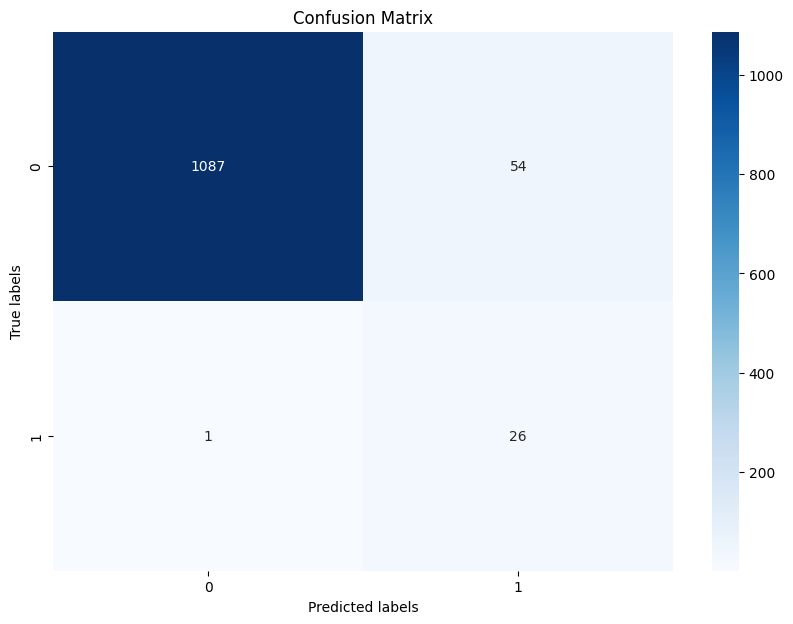

Model and preprocessors saved successfully.


In [59]:
# Preprocess the data
data_for_model = combined_data.drop(columns=['timestamp'])  # Drop timestamp
X = data_for_model.drop(columns=['label'])
y = data_for_model['label'].values


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

print(y_encoded)

sequence_length = 60
step = 5

def create_sequences(X, y, sequence_length, step):
    X_seq, y_seq = [], []
    for i in range(0, len(X) - sequence_length, step):
        X_seq.append(X[i: i + sequence_length])
        # For simplicity, we take the label of the last timestep in each sequence
        y_seq.append(y[i + sequence_length - 1])
    return np.array(X_seq), np.array(y_seq)

def create_sequences2(X, y, sequence_length, step, fall_detection_threshold):
    X_seq, y_seq = [], []
    for i in range(0, len(X) - sequence_length, step):
        seq = X[i: i + sequence_length]
        # Assuming `y` is a binary indicator where 1 represents a fall
        seq_labels = y[i: i + sequence_length]
        
        # Label the sequence as a fall if the fall_detection_threshold is met
        if np.mean(seq_labels) >= fall_detection_threshold:
            label = 1  # Fall detected
        else:
            label = 0  # No fall detected
        
        X_seq.append(seq)
        y_seq.append(label)
    return np.array(X_seq), np.array(y_seq)


In [ ]:
X_sequences, y_sequences = create_sequences2(X_scaled, y, sequence_length, step, 0.2)

# Reshaping for LSTM
X_sequences = X_sequences.reshape((X_sequences.shape[0], sequence_length, X_scaled.shape[1]))

print(np.mean(y_sequences))
# Now, X_sequences and y_sequences can be used for training the LSTM model
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)
#print(X_test)


# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)


# Convert class weights to a dictionary to pass to Keras
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)


model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    LSTM(32),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Updated for binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Train the model with binary labels
model.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stopping], batch_size=64, class_weight=class_weight_dict)

# Save the model and preprocessors
model.save('LSTM_model_binary.keras')
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Predict the test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)
#y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class labels

# Calculate F1 Score
f1 = f1_score(y_test, y_pred, average='weighted')  # 'weighted' accounts for label imbalance
print(f"F1 Score: {f1}")

# calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

#plot it
# Plotting confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

print("Model and preprocessors saved successfully.")

In [55]:
from tensorflow.keras.models import load_model

# Load the trained LSTM model
model = load_model('LSTM_model_binary.keras')
# Load the scaler
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

